# Лабораторная работа №3

Классификация изображений. Сверточные сети. Предобученные
сверточные сети.

# Подготовка среды

In [ ]:
# установим kaggle
%pip install kagglehub

Note: you may need to restart the kernel to use updated packages.


In [2]:
# скачаем датасет
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alxmamaev/flowers-recognition")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Admin\.cache\kagglehub\datasets\alxmamaev\flowers-recognition\versions\2


# Подготовка датасета

In [4]:
seed = 7


In [5]:
from keras.preprocessing import image_dataset_from_directory
import tensorflow as tf

data_dir = path + "\\flowers"

# читаем датасет из папки: тренировочный и валидационный
train_ds, val_ds = image_dataset_from_directory(
    data_dir,
    image_size=(150, 150),
    batch_size=32, # пакеты по 32 изображения - мини-пакетное обучение
    label_mode='categorical',
    validation_split=0.2, # 20% под валидационный датасет
    subset="both",
    seed=seed
)

batches = tf.data.experimental.cardinality(val_ds)

# разделяем валидационный датасет на тестовый и валидационный)
test_ds = val_ds.take(batches // 2)
val_ds = val_ds.skip(batches // 2)

print(f"{tf.data.experimental.cardinality(val_ds).numpy()} for validation")
print(f"{tf.data.experimental.cardinality(test_ds).numpy()} for test")


Found 4317 files belonging to 5 classes.
Using 3454 files for training.
Using 863 files for validation.
14 for validation
13 for test


Проверим сбалансированность данных (распределение по классам)

In [ ]:
import numpy as np

y_labels = []
for images, labels in train_ds:
    y_labels.extend(labels.numpy())
for images, labels in val_ds:
    y_labels.extend(labels.numpy())
for images, labels in test_ds:
    y_labels.extend(labels.numpy())

class_counts = np.sum(y_labels, axis=0)

for i, count in enumerate(class_counts):
    print(f"Класс {i}: {int(count)} примеров")

Класс 0: 764 примеров
Класс 1: 1052 примеров
Класс 2: 784 примеров
Класс 3: 733 примеров
Класс 4: 984 примеров


Данные достаточно сбалансированы, нет сильного преимущества одних классов над другими 

# 1. Обучение Conv2D и MaxPooling

## Сборка модели

In [ ]:
import tensorflow as tf
from keras import layers, models, regularizers, optimizers

# количество классов
num_classes = 5

regularizer = regularizers.l1(0.0001)
#regularizer = None

model = models.Sequential([
    # входные изображения
    layers.Input(shape=(150, 150, 3)),    
    
    # аугментация (должно работать только при обучении)
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(0.1),

    # нормализация - пиксели по каждому из цветов занимают байт. приводим к диапазону [0,1]
    layers.Rescaling(1./255),

    # Conv2D + MaxPooling2D
    layers.Conv2D(32, (3, 3), activation='relu', padding="same",
                  kernel_regularizer=regularizer),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding="same",
                  kernel_regularizer=regularizer),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(96, (3, 3), activation='relu', padding="same",
                  kernel_regularizer=regularizer),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(96, (3, 3), activation='relu', padding="same",
                  kernel_regularizer=regularizer),
    layers.MaxPooling2D((2, 2)),

    # полносвязные слои для получения классификации
    layers.Flatten(),
    layers.Dense(512, activation='relu', 
                 kernel_regularizer=regularizer),
    # layers.Dense(32, activation='relu', 
    #              kernel_regularizer=regularizer),
    #layers.Dropout(0.5), # Хорошая практика вместе с L1
    
    # Выходной слой для многоклассовой классификации
    layers.Dense(num_classes, activation='softmax') 
])

# 4. Компиляция
model.compile(
    optimizer=optimizers.Adam(0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_5 (RandomFlip)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_5               │ (None, 150, 150, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_5 (RandomZoom)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_brightness_5             │ (None, 150, 150, 3)    │             0 │
│ (RandomBrightness)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 37, 37, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 18, 18, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 18, 18, 96)     │        83,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 9, 9, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 7776)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │     3,981,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,142,213 (15.80 MB)

 Trainable params: 4,142,213 (15.80 MB)

 Non-trainable params: 0 (0.00 B)

## Обучение модели

In [35]:
history = model.fit(
    train_ds, 
    validation_data=val_ds, 
    #steps_per_epoch=50,
    epochs=100)

Epoch 1/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 44s 390ms/step - accuracy: 0.3049 - loss: 2.9367 - val_accuracy: 0.4251 - val_loss: 1.6964
Epoch 2/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 51s 473ms/step - accuracy: 0.5035 - loss: 1.5184 - val_accuracy: 0.5369 - val_loss: 1.4941
Epoch 3/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 51s 468ms/step - accuracy: 0.5483 - loss: 1.3922 - val_accuracy: 0.5794 - val_loss: 1.3773
Epoch 4/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 48s 444ms/step - accuracy: 0.5935 - loss: 1.2623 - val_accuracy: 0.5772 - val_loss: 1.3798
Epoch 5/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 48s 443ms/step - accuracy: 0.6022 - loss: 1.2113 - val_accuracy: 0.5257 - val_loss: 1.4569
Epoch 6/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 50s 460ms/step - accuracy: 0.6245 - loss: 1.1613 - val_accuracy: 0.6130 - val_loss: 1.2209
Epoch 7/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 56s 520ms/step - accuracy: 0.6288 - loss: 1.1440 - val_accuracy: 0.6242 - val_loss: 1.2666
Epoch 8/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 48s 440ms/step - accuracy: 0.6329 -

Построим график потерь и точности

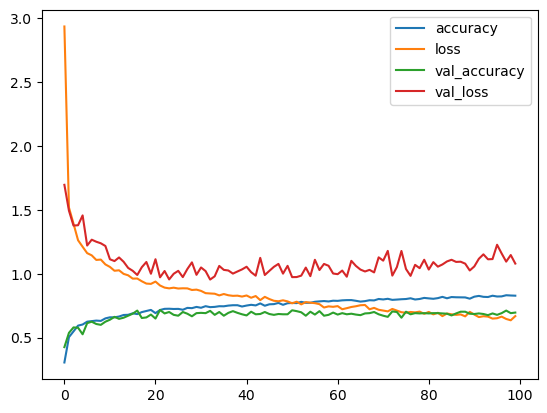

In [ ]:
#model.save("C:\\Users\\Admin\\Desktop\\GUAP\\IAD\\lab3\\classifier.keras")

import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot()
plt.show()

## Проверим точность и потери на тестовом наборе данных

In [37]:
model.evaluate(test_ds)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.7043 - loss: 1.0715


[1.071543574333191, 0.7043269276618958]

Точность на тестовой выборке сравнима с точностью на валидационной выборке

# 2. Трансферное обучение

## Создадим сверточное ядро

In [13]:
# todo смотреть лекцию делать нейросеть
import keras

# 
conv_base = keras.applications.MobileNetV2(
    input_shape=(150,150,3),
    alpha=1.0,
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
)

conv_base.trainable = False

conv_base.summary()

C:\Users\Admin\AppData\Local\Temp\ipykernel_30704\3791830724.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  conv_base = keras.applications.MobileNetV2(


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 75, 75,    │        864 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 75, 75,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 75, 75,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 75, 75,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 75, 75,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 75, 75,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 75, 75,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 75, 75,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 77, 77,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 38, 38,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 38, 38,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 38, 38,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 38, 38,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

## Соберем пайплайн

In [17]:
from keras.applications import mobilenet_v2

pred_model = models.Sequential([
    # входные изображения
    layers.Input(shape=(150, 150, 3)),    
    
    # аугментация (должно работать только при обучении)
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(0.1),

    # препроцессинг для сверточного ядра
    layers.Lambda(mobilenet_v2.preprocess_input, name="preprocessing"),

    # сверточное ядро
    conv_base,

    # полносвязный классификатор
    layers.Flatten(),
    layers.Dense(256),
    layers.Dropout(0.5),
    layers.Dense(5, activation="softmax")
])

pred_model.compile(
    optimizer=optimizers.Adam(0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

pred_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_4 (RandomFlip)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_4               │ (None, 150, 150, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_4 (RandomZoom)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_brightness_4             │ (None, 150, 150, 3)    │             0 │
│ (RandomBrightness)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preprocessing (Lambda)          │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 32000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │     8,192,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451,525 (39.87 MB)

 Trainable params: 8,193,541 (31.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Обучение

In [18]:
import keras.callbacks as clbks

callbacks = [
    clbks.EarlyStopping(monitor="val_loss", patience=20),
    clbks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=7)
]

pred_history = pred_model.fit(
    train_ds,
    epochs=80,
    validation_data=val_ds,
    callbacks=callbacks
)

Epoch 1/80
108/108 ━━━━━━━━━━━━━━━━━━━━ 42s 346ms/step - accuracy: 0.7082 - loss: 19.0873 - val_accuracy: 0.8210 - val_loss: 9.2984 - learning_rate: 0.0010
Epoch 2/80
108/108 ━━━━━━━━━━━━━━━━━━━━ 35s 323ms/step - accuracy: 0.8075 - loss: 10.9645 - val_accuracy: 0.7539 - val_loss: 15.2330 - learning_rate: 0.0010
Epoch 3/80
108/108 ━━━━━━━━━━━━━━━━━━━━ 35s 324ms/step - accuracy: 0.8309 - loss: 8.3308 - val_accuracy: 0.7987 - val_loss: 11.4608 - learning_rate: 0.0010
Epoch 4/80
108/108 ━━━━━━━━━━━━━━━━━━━━ 35s 321ms/step - accuracy: 0.8471 - loss: 6.7108 - val_accuracy: 0.8054 - val_loss: 11.8353 - learning_rate: 0.0010
Epoch 5/80
108/108 ━━━━━━━━━━━━━━━━━━━━ 35s 324ms/step - accuracy: 0.8772 - loss: 4.8581 - val_accuracy: 0.8300 - val_loss: 7.8194 - learning_rate: 0.0010
Epoch 6/80
108/108 ━━━━━━━━━━━━━━━━━━━━ 35s 324ms/step - accuracy: 0.8830 - loss: 3.8715 - val_accuracy: 0.8389 - val_loss: 6.8386 - learning_rate: 0.0010
Epoch 7/80
108/108 ━━━━━━━━━━━━━━━━━━━━ 35s 327ms/step - accuracy

График потерь и точности

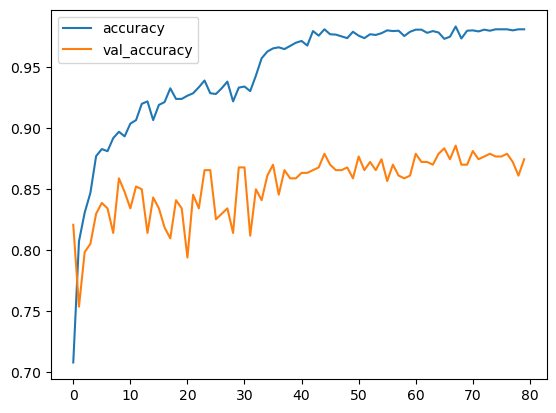

In [25]:
pd.DataFrame(pred_history.history)[["accuracy", "val_accuracy"]].plot()
plt.show()

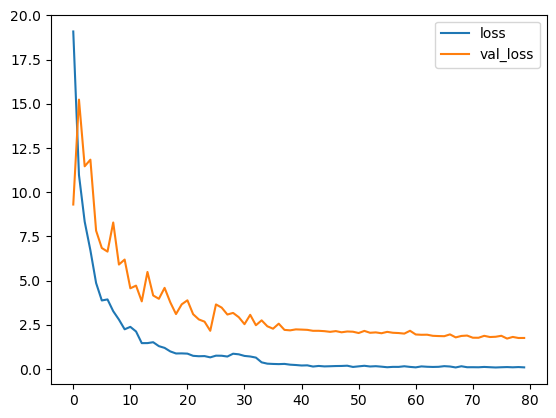

In [26]:
pd.DataFrame(pred_history.history)[["loss", "val_loss"]].plot()
plt.show()

## Проверка на тестовом наборе

In [28]:
#pred_model.save("C:\\Users\\Admin\\Desktop\\GUAP\\IAD\\lab3\\mobile_classifier.keras")

pred_model.evaluate(test_ds)

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 202ms/step - accuracy: 0.8510 - loss: 2.1384


[2.1383538246154785, 0.8509615659713745]

На тестовом наборе модель показала 85% точности - примерно так же, как и на валидационной выборке.

# 3. Сравнение моделей

Сравним модель, обученную с нуля, и модель, обученную с использованием предобученного сверточного блока.

In [43]:
# собираем тестовые метки в один массив
test_labels = []
for x,labels in test_ds:
    test_labels.extend(labels.numpy())

test_labels = np.argmax(test_labels, axis=1)

# наименования классов
class_names = train_ds.class_names

Отчет о классификации для обученной с нуля модели

In [45]:
from sklearn.metrics import classification_report

model.evaluate(test_ds)
pred_labels = model.predict(test_ds)
pred_labels = np.argmax(pred_labels, axis=1)
print(classification_report(test_labels, pred_labels, target_names=class_names))

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.7043 - loss: 1.0715
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
              precision    recall  f1-score   support

       daisy       0.77      0.71      0.74        69
   dandelion       0.80      0.66      0.72        96
        rose       0.45      0.46      0.46        54
   sunflower       0.74      0.84      0.79        83
       tulip       0.70      0.75      0.73       114

    accuracy                           0.70       416
   macro avg       0.69      0.69      0.69       416
weighted avg       0.71      0.70      0.70       416



Отчет о классификации для модели, обученной с использованием сверточного блока

In [48]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix

pred_model.evaluate(test_ds)
pred_labels = pred_model.predict(test_ds)
pred_labels = np.argmax(pred_labels, axis=1)
print(classification_report(test_labels, pred_labels, target_names=class_names))
#print(multilabel_confusion_matrix(test_labels, pred_labels, labels=class_names))

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - accuracy: 0.8510 - loss: 2.1384
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step
              precision    recall  f1-score   support

       daisy       0.82      0.87      0.85        69
   dandelion       0.98      0.83      0.90        96
        rose       0.72      0.76      0.74        54
   sunflower       0.86      0.93      0.89        83
       tulip       0.84      0.84      0.84       114

    accuracy                           0.85       416
   macro avg       0.84      0.85      0.84       416
weighted avg       0.86      0.85      0.85       416



Из метрик видно, что сеть, обученная с использованием предобученного блока, показала гораздо более лучшие результаты при распознавании всех классов. Интересно, что розы распознаются заметно хуже остальных классов в обеих моделях.

Также стоит отметить, что в обеих моделях наблюдается переобучение - на тренировочной выборке показатели сильно лучше, чем на валидационной и тестовой. Для датасета приведенной небольшой размерности это ожидаемо.

# Вывод

В ходе выполнения третьей лабораторной работы обучено две модели многоклассовой классификации изображений.
Использован датасет с изображениями цветов "alxmamaev/flowers-recognition".

Первая нейросеть - сверточная нейросеть из слоев Conv2D и MaxPooling2D. 
Вторая нейросеть - нейросеть с предобученным ядром MobileNetV2 с добавлением полносвязного классификатора. Ядро предобучено на наборе данных ImageNet.

С помощью сравнения метрик на тестовом наборе показано, что нейросеть с предобученным ядром имеет лучшую эффективность, что показывает оправданность использования предобученных нейросетей общего назначения при создании моделей для решения конкретных прикладных задач.
